# A3: Multi-objective Optimization

---

*Purpose*: Many real engineering problems have multiple objectives. In this case optimization is greatly complicated. In this assignment you'll learn about non-dominance, the Pareto frontier, and how to use optimization to identify a frontier of efficient designs.

*Learning Objectives*: By working through this assignment, you will 
- use pipe-enabled Grama verbs to write *readable* code
- use `gr.eval_min()` to solve optimization problems with Grama models
- learn the basic concepts of multi-objective optimization: non-dominance and the Pareto frontier
- use scalarization techniques and repeated optimization to construct a Pareto frontier

*Reading*:
- Kochenderfer and Wheeler, Ch 12.1, 12.2, 12.3



### Assignment Checklist

1. [?] Make sure you have answered all questions. These are marked with a **qX.Y**
1. [?] Make sure you complete the Project Task at the end of the assignment. These will scaffold your project progress during the semester.
1. [?] Make sure your notebook passes all `assert()` statements. You will not get full credit for the assignment if a single `assert()` fails.
1. [?] Make sure your notebook runs: `Kernel > Restart kernel and run all cells...`
1. [?] Upload your notebook to Canvas.


### Grading Rubric

Every assignment is worth 10 points; it is not possible to receive less than 0 points. For each question (qX.Y) on a given assignment, the following grading rubric will be applied. For every NI that you receive, one point will be subtracted from your assignment total. For reference, to receive an A- in this class, you will need an average of 9 points across your 5 best assignments, meaning you need to have at most one mistake on your final submission for 5 assignments. To achieve this, you should take advantage of both the Draft and Final submission deadlines.

| Category     | Needs Improvement (NI)                     | Satisfactory (S)                       |
|--------------|--------------------------------------------|----------------------------------------|
| Effort       | qX.Y left unattempted                      | qX.Y attempted                         |
| Assertions   | Code does not pass an `assert()`           | All `assert()`s pass, or no assertions |
| Observations | Any point under *observe* left unattempted | All *observe*s attempted and correct,  |
|              | Provided an incorrect observation          | or no *observe*s for that q            |


## S1: Sinews and Pipes

---

First, we'll learn some more useful Grama stuff: Pipelines, the data pronoun, and sinew plots.

In [1]:
import grama as gr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

from grama.models import make_cantilever_beam

# Define the data pronoun as DF
DF = gr.Intention()

# Set figure options
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

## Sinew Plots

We'll often have to make sense of high-dimensional functions. One of the most useful things we can do as a "first check" of a model is to construct *sinew plots*. Let's look at a very simple function to get some intuition: Here's the function

$$f(x, a) = a \exp(x)$$

And here's an implementation in Grama:


In [2]:
## NOTE: No need to edit
md_simple = (
    gr.Model()
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            f=df.a * np.exp(df.x)
        ),
        var=["x", "a"],
        out=["f"]
    )
    >> gr.cp_bounds(
        a=(-1, +1),
        x=(-1, +1),
    )
)


We know this function is going to be *linear* in its argument $a$, and *exponential* in its argument $x$. So if we were to *hold all other variables constant* and vary one input at a time, we could take a look at the effect of just one input. This is what a sinew plot does.

*Aside*: Some folks call these [ceteris paribus plots](https://ema.drwhy.ai/ceterisParibus.html), where *ceteris paribus* is latin for *all else equal*. I'm not a fan of dead languages, so I just call them sinews.

We can get a better sense by visualizing which points the sinew operation will evaluate:


Design runtime estimates unavailable; model has no timing data.
Calling plot_sinew_inputs....


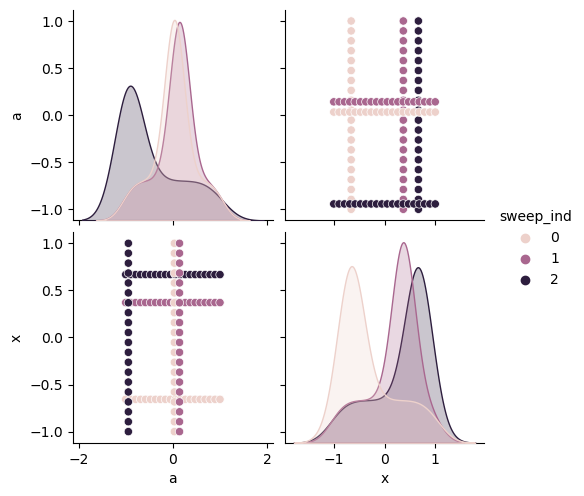

In [3]:
gr.plot_auto(
    gr.eval_sinews(
        md_simple,
        df_det="swp",
        skip=True,
        n_density=20,
        n_sweeps=3,
        seed=101,
    )
)

Setting `skip=True` tells Grama not to evaluate the functions, but to just give us the points it plans to evaluate. Calling `plot_auto()` on the result uses some metadata to construct an automatic plot that helps visualize the results.

This plot shows what `eval_sinews()` does: We pick random points in the `a, x` plane (`n_sweeps` of them) and sweep parallel to the axes of `a` and `x`. This gives us a set of points to evaluate. If we get rid of the `skip` keyword, Grama will evaluate the function and show us the response against each input variable:


Calling plot_sinew_outputs....


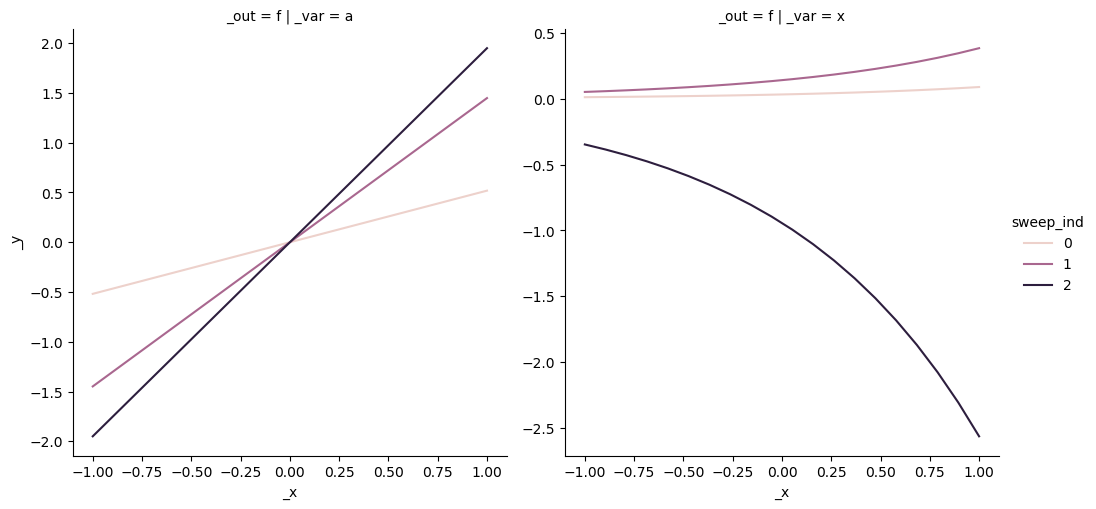

In [4]:
gr.plot_auto(
    gr.eval_sinews(
        md_simple,
        df_det="swp",
#         skip=True,
        n_density=20,
        n_sweeps=3,
        seed=101,
    )
)

Here we can see that indeed, the function is linear in `a` and exponential in `x`. However, we can also see how *other* variables modulate those effects. We can see that, depending on the value of `a`, the function could either grow positively or negatively in `x`. And for the linear growth in `a`, its slope is determined by `x`.

For a modest number of variables---say fewer than 5---a sinew plot can help us make sense of our model. With more variables, it's hard to make sense of all the complex interactions between variables in the function. If you have a model with many more variables, you can ask me about *dimension reduction* techniques sometime.


## Pipelines

Grama is designed around *analysis pipelines*, in the style of [functional programming](https://en.wikipedia.org/wiki/Functional_programming). In a pipeline one successively applies functions; an advantage of this functional style is that one can easily read individual steps corresponding to each function.

To help make functional code readable, Grama functions overload the shift operator `>>` to serve as a *pipe*. The pipe takes its left hand side (LHS), and inserts the LHS as the first argument to the function on its right.

**Important concept**: When you see `x >> fun(*args)`, you should think of this as equivalent to `fun(x, *args)`.

This pipe operator lets us *transform* code to make it more readable. For instance, the following code is borderline unintelligible:


In [5]:
# NOTE: No need to edit, just run and inspect
# gr.plot_auto(
#     gr.eval_sinews(
#         make_cantilever_beam(),
#         df_det="nom",
#     )
# )

This code is hard to read in part because we need to start from the *inside* of the functions to understand where the computation starts. This is made considerably more readable by introducing *intermediate variables*: The following code does *exactly* the same thing as the code above, but assigns intermediate variables `md_beam` and `df_sweep`.


In [6]:
# NOTE: No need to edit, just run and inspect
md_beam = make_cantilever_beam()
df_sweep = gr.eval_sinews(md_beam, df_det="nom")
# gr.plot_auto(df_sweep)


The pipe operator `>>` allows us to remove the intermediate variables, which can be useful when we're carrying out many operations. Let's rewrite the code one last time using pipes. Note that the use of parentheses around the code allows us to use newlines without needing a line continuation character `\`.


In [7]:
# NOTE: No need to edit, just run and inspect
(
    md_beam
#     >> gr.ev_sinews(df_det="nom")
#     >> gr.pt_auto()
)


Note that the *prefix* for the grama functions changed; the pipe-enabled version of the function has a two-letter prefix. The prefixes also denote the inputs and outputs of the function:

| Prefix (Short) | Input | Output |
|---|---|---
| `eval` (`ev`) | Model | DataFrame |
| `fit` (`ft`) | DataFrame | Model |
| `comp` (`cp`) | Model | Model |
| `tran` (`tf`) | DataFrame | DataFrame |
| `plot` (`pt`) | DataFrame | (Plot) |

You don't need to memorize this table; you can come back and reference it (or better yet, save the relevant [documentation page](https://py-grama.readthedocs.io/en/latest/source/language.html#verbs)). Just know that you can tell a lot about a (Grama) function by looking at its prefix; that alone tells you what type of input it will take, and what type of output it will provide.


### q1.1 Rewrite this code with pipes

Rewrite the following code using the pipe `>>` operator.

*Hint*: If you do this correctly, you should get an identical set of histograms as the existing code.


eval_monte_carlo() is rounding n...
Calling plot_hists....


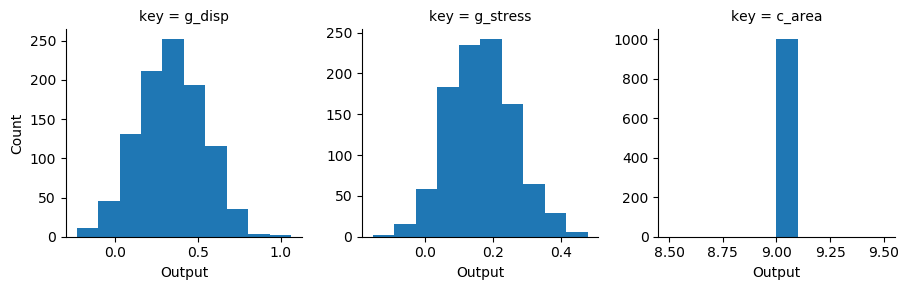

In [8]:
###
# TASK: Re-write the following code using pipes `>>`
###

# NOTE: No need to edit; this is the code you'll translate
# md_beam = make_cantilever_beam()
# df_mc = gr.eval_monte_carlo(md_beam, n=1e3, df_det="nom")
# gr.plot_auto(df_mc)
(
    md_beam
    >> gr.ev_monte_carlo(n=1e3, df_det="nom")
    >> gr.pt_auto()
)
# TASK: Re-write this code with pipes `>>` to 
#       eliminate intermediate variables



## The data pronoun

Grama also provides a function `Intention()`, which allows us to define a *data pronoun*. The setup code above assigns this with `DF = gr.Intention()`, which means we can use `DF` as a data pronoun.

### Filtering

The use of this shorthand allows us to simplify code. For instance, we can re-write the following filter code:

```
df_longdataname[df_longdataname.x > df_longdataname.y]
```

Using a call to `gr.tf_filter()` using the data pronoun

```
df_longdataname >> gr.tf_filter(DF.x > DF.y)
```

### Mutating

The use of the data pronoun also allows us to avoid assigning intermediate variables. If we wished to filter then modify data, we would need to do this in pure pandas with an intermediate DataFrame:

```
df_tmp = df_data[df_data.x > x_threshold]
df_tmp.y = df_tmp.x ** 2
```

Using `gr.tf_mutate()` we can add / edit a column, and we can use this in a pipeline with a filter to compose the two operations.

```
(
    df_data
    >> gr.tf_filter(DF.x > x_threshold)
    >> gr.tf_mutate(y=DF.x ** 2)
)
```


### q1.2 Use the data pronoun to filter

Recreate the following pure-pandas filtering operation using a *single* call to `gr.tf_filter()` and the data pronoun `DF`.


In [9]:
###
# TASK: Recreate the following data manipulation using
#       `gr.tf_filter()` and the data pronoun `DF`
###

# NOTE: No need to edit; this sets up a toy dataset
df_foo = gr.df_make(
    x=[0, 1, 2],
    y=[2, 1, 0],
)

# NOTE: No need to edit; recreate this with a single filter
df_tmp = df_foo.copy()
df_tmp["d"] = df_tmp.x**2 + df_tmp.y**2
df_tmp["b"] = df_tmp.d <= 2
df_tmp = df_tmp[df_tmp.b]

# TASK: Recreate the filtering operation above, but do so with a 
#       single call of gr.tf_filter() using the data pronoun DF
df_pipe = df_foo.copy()

df_pipe = (
    df_pipe
        >> gr.tf_filter((DF.x**2 + DF.y**2) <= 2)
#         >> gr.tf_mutate(d=DF.x**2 + DF.y**2)
#         >> gr.tf_filter(DF.d <= 2)
)

# NOTE: No need to edit; use to check your answer
assert(df_pipe.equals(df_tmp[["x", "y"]].reset_index(drop=True)))
print("Success!")


Success!


## `eval_min()` and pipeline model adjustments

Let's use these ideas to make "last minute" adjustments to a model before we use it in an optimization problem.

First, let's introduce `gr.eval_min()`: This is a *wrapper* for `scipy.optimize.minimize` that allows us to set an objective and constraints based on model outputs. If we were not using `gr.eval_min()`, we would need to write our own wrapper functions to use a Grama model with `scipy.optimize.minimize`.


In [10]:
# NOTE: No need to edit; run and inspect
md_base = (
    gr.Model("Example model")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            u=df.x + df.y + 1,
            v=df.x - df.y - 1,
        ),
        var=["x", "y"],
        out=["u", "v"],
    )
    >> gr.cp_bounds(
        x=(-1, +1),
        y=(-1, +1),
    )
)

# The following pipeline modifies a model and runs an optimization
df_res_tmp = (
    md_base
    # Add another function to md_base, summarizing its outputs
    >> gr.cp_function(
        fun=lambda x: (0.5 * x[0] + 0.5 * x[1] - 1)**2,
        var=["u", "v"],
        out=["obj"],
    )
    # Run optimization on this new objective
    >> gr.ev_min(out_min="obj")
)
df_res_tmp



,y,x,y_0,x_0,u,v,obj,success,message,n_iter
0,0.0,1.0,0.0,0.0,2.0,-1.110223e-16,0.0,True,Optimization terminated successfully.,2


We can use this "just in time" adjustment to apply the scalarization idea you read about in Kochenderfer and Wheeler.

### q1.3 Optimize with `gr.eval_min()`

Using `md_base` as a starting point, solve the following optimization problem:

$$\min\, x^2 + y^2$$
$$\text{wrt.}\, x, y$$
$$\text{s.t.}\, u(x, y) \leq 0$$
$$\text{s.t.}\, v(x, y) \leq 0$$

Solve the optimization problem with `gr.eval_min()`.

*Hint*: Remember to use `Shift + Tab` to read the documentation for `gr.eval_min()`!


In [11]:
###
# TASK: Implement and solve the optimization problem above
###

df_q1_3 = (
    md_base
    >> gr.cp_function(
        fun=lambda x: x[0]**2 + x[1]**2,
        var=["x", "y"],
        out=["obj"],
    )
    >> gr.ev_min(out_min="obj", out_leq=["u", "v"], n_restart=1)
)
print(df_q1_3)

# NOTE: No need to edit, use this to check your solution
# assert(abs(df_q1_3.x[0] + 0.5) < 1e-6)
# assert(abs(df_q1_3.y[0] + 0.5) < 1e-6)
print("Success!")
df_q1_3


     y    x  y_0  x_0             u    v  obj  success  \
0 -0.5 -0.5  0.0  0.0  3.330669e-16 -1.0  0.5     True   

                                 message  n_iter  
0  Optimization terminated successfully.       3  
Success!


,y,x,y_0,x_0,u,v,obj,success,message,n_iter
0,-0.5,-0.5,0.0,0.0,3.330669e-16,-1.0,0.5,True,Optimization terminated successfully.,3


One last thing; because vectorized Grama functions take DataFrames and return DataFrames, we can use pipelines *within* a Grama function. This allows us to do trivial things in a more complicated way (which is not compelling):


In [12]:
## NOTE: No need to edit; this demonstrates using pipeline tools
# inside a Grama function
md_silly = (
    gr.Model()
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(f=df.x)
        >> gr.tf_mutate(g=DF.f + DF.y),
        var=["x", "y"],
        out=["f", "g"]
    )
    >> gr.cp_bounds(
        x=(0, 1),
        y=(0, 1)
    )
)

But the use of pipeline-enabled data manipulation allows us to do *very sophisticated* data operations within a Grama model, which will enable important operations we'll see in NB4. The tricky thing to look out for is to *not* get the variables `df` and `DF` confused; if you run into issues with your code, keep a look out for swapping the two.

We'll use these tools for combining model outputs in our efforts to tackle *multi-objective optimization* below.


## S2: Multi-objective Optimization: The Pareto Frontier

---

To this point we've studied problems that have **just one** objective to optimize. However real engineering problems often have more than one objective. This situation is called *multi-objective optimization*, and it is *inherently* more complicated than single-objective optimization.

The following figure illustrates two objective function axes, both of which we wish to maximize. We see a single candidate at the center of the diagram, and the quadrants about that candidate are labeled:

<!-- <img src="obj-multi.png" width="400"> -->

In multi-objective optimization we are *not* guaranteed to be able to order two candidates as inherently better or worse. Instead two candidates can be mutually *non-dominating*---this occurs when one candidate is superior along one or more axes, but the other candidate is superior along different axes. 


<!-- <img src="obj-ex.png" width="400"> -->

The existence of non-dominated candidate pairs means *there is no unique optimum* in the multi-objective setting. Instead, there is a set of non-dominated candidates, as shown in the example above. This set is called the [Pareto frontier](https://en.wikipedia.org/wiki/Pareto_efficiency). 

The following code example illustrates a Pareto frontier with the aircraft dataset, highlighting those cases that have minimal body weight but carry maximal passengers. The function `gr.pareto_min()` is a helper function that computes Pareto-efficient points in a given dataset.


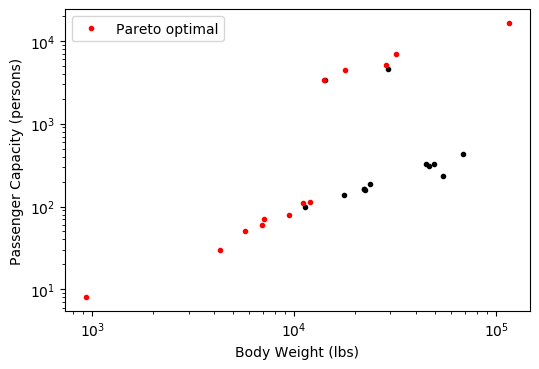

In [13]:
# NOTE: No need to edit; this illustrates a Pareto frontier
# Load the data
filename_aircraft = "wing_weight.csv"
df_aircraft = pd.read_csv(filename_aircraft)

# Wrangle the dataset into a usable form
# NOTE: If you want to learn how to do this, take Data Science!
aircraft = df_aircraft.drop(
    ["Group", "Name", "Symbol", "Units"],
    axis=1
).columns
df_properties = (
    df_aircraft
    >> gr.tf_gather("aircraft",  "value",  aircraft)
    >> gr.tf_select(DF.Symbol, DF.aircraft, DF.value)
    >> gr.tf_spread("Symbol", "value", convert=True)
    # Note that I use -N_p to maximize N_p
    >> gr.tf_mutate(pareto=gr.pareto_min(DF.W_3, -DF.N_p))
)

# Visualize
plt.figure()
plt.plot(
    df_properties[~df_properties.pareto]["W_3"], 
    df_properties[~df_properties.pareto]["N_p"], 
    "k."
)
plt.plot(
    df_properties[df_properties.pareto]["W_3"], 
    df_properties[df_properties.pareto]["N_p"], 
    "r.",
    label="Pareto optimal"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Body Weight (lbs)")
plt.ylabel("Passenger Capacity (persons)")
plt.legend(loc=0)


It looks like there might be two very different classes of aircraft in this dataset (I see two parallel lines of aircraft, which looks like two separate groups). Clearly the top group is more efficient at carrying passengers than the lower one, for fixed weight. However, the bottom group might be optimized for other criteria. You could take a closer look at the dataset to figure out more!


### q2.1 Identify a Pareto Frontier

The following is the [Binh and Korn](https://en.wikipedia.org/wiki/Test_functions_for_optimization#Test_functions_for_multi-objective_optimization) optimization problem.

$$\min\, f_1, f_2$$
$$\text{wrt.}\, x, y$$
$$\text{s.t.}\, g_1 \leq 0$$
$$\text{s.t.}\, g_2 \geq 0$$
$$\text{s.t.}\, 0 \leq x \leq 5$$
$$\text{s.t.}\, 0 \leq y \leq 3$$

The following code generates data from this problem. Your task is to filter out only those points satisfying the constraints, and to identify the Pareto-optimal points. Answer the questions below.


eval_monte_carlo() is rounding n...


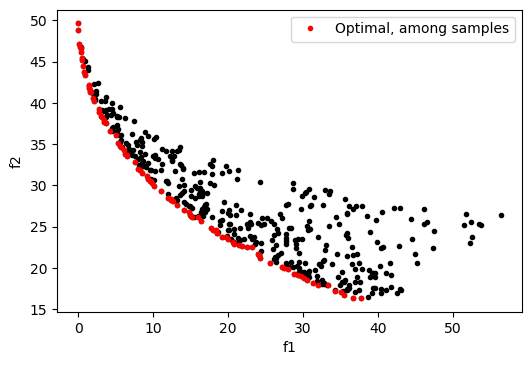

In [14]:
###
# TASK: Filter the data that satisfy the constraints
#       and add a column that identifies Pareto points
###

# NOTE: No need to edit, this sets up a model to optimize
md_BK = (
    gr.Model("Binh and Korn model")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            f1=4 * df.x**2 + 4 * df.y**2
        ),
        var=["x", "y"],
        out=["f1"],
    )
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            f2=(df.x - 5)**2 + (df.y - 5)**2
        ),
        var=["x", "y"],
        out=["f2"],
    )
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            g1_leq=(df.x - 5)**2 + df.y**2 - 25
        ),
        var=["x", "y"],
        out=["g1_leq"],
    )
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            g2_geq=(df.x - 8)**2 - (df.y + 3)**2 - 7.7
        ),
        var=["x", "y"],
        out=["g2_geq"],
    )
    >> gr.cp_bounds(
        x=(0, 5),
        y=(0, 3),
    )
)
# Generate samples uniformly across the domain
df_random = (
    md_BK
    >> gr.cp_marginals(
        x=dict(dist="uniform", loc=0, scale=5),
        y=dict(dist="uniform", loc=0, scale=3),
    )
    >> gr.cp_copula_independence()
    >> gr.ev_monte_carlo(n=1e3, df_det="nom", seed=102)
)

# TASK: Filter the data, compute the Pareto points
df_BK = (
    df_random
    >> gr.tf_filter(DF.g1_leq <= 0)
    >> gr.tf_filter(DF.g2_geq >= 0)
    >> gr.tf_mutate(pareto=gr.pareto_min(DF.f1, DF.f2))
)


# NOTE: No need to edit; this visualizes your results
plt.figure()
plt.plot(df_BK.f1, df_BK.f2, "k.")
plt.plot(
    df_BK[df_BK.pareto].f1,
    df_BK[df_BK.pareto].f2,
    "r.",
    label="Optimal, among samples",
)

plt.xlabel("f1")
plt.ylabel("f2")
plt.legend(loc=0)


*Observe*:

- What shape---roughly---does the Pareto frontier have?
  - The frontier roughly mimics a decreasing exponential curve.
- Here we approximated the Pareto frontier using *random sampling*. Try increasing the `n` in `gr.ev_monte_carlo()` above; what happens when you increase `n`?
  - The frontier more closely resembles a decreasing exponential curve.


### q2.2 Scalarization

Use the weight method (Kochenderfer and Wheeler, Ch 12.3) to scalarize the objective $f_1, f_2$ and find a candidate near the "middle" of the Pareto frontier. Use `gr.ev_min()` to solve the optimization. Answer the question below.

*Hint*: Remember that you can use `md_BK.printpretty()` to inspect the model to determine the names of its outputs.


model: Binh and Korn model

  inputs:
    var_det:
      y: [0, 3]
      x: [0, 5]
    var_rand:
    copula:
        None
  functions:
    f0: ['x', 'y'] -> ['f1']
    f1: ['x', 'y'] -> ['f2']
    f2: ['x', 'y'] -> ['g1_leq']
    f3: ['x', 'y'] -> ['g2_geq']
    w2    y    x   w1  w2_0  y_0  x_0  w1_0  g1_leq  g2_geq   f1   obj    f2  \
0  1.0  1.0  1.0  1.0   1.0  1.5  2.5   1.0    -8.0    25.3  8.0  40.0  32.0   

   success                                message  n_iter  
0     True  Optimization terminated successfully.       5  


Text(0, 0.5, 'f2')

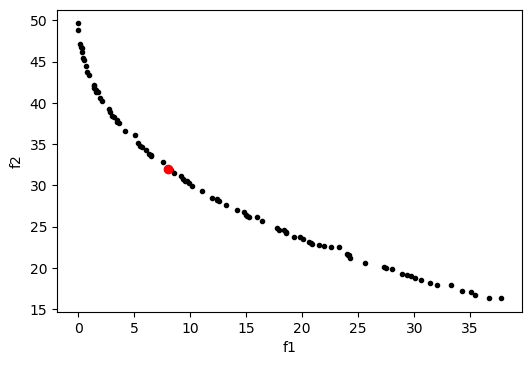

In [15]:
###
# TASK: Scalarize the objectives f1, f2 with the weight method,
#       solve the optimization problem to identify a point on the
#       Pareto frontier
###
md_BK.printpretty()
df_BK_opt = (
    md_BK
    >> gr.cp_bounds(
        w1=(1, 1),
        w2=(1, 1),
    )
#     >> gr.tf_mutate(
#         w1 = 1,
#         w2 = 1,
#     )
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            obj = df.w1*df.f1 + df.w2*df.f2
        ),
        var=["f1", "f2", "w1", "w2"],
        out=["obj"],
    )
    >> gr.ev_min(out_min="obj", n_restart=1)
)
    
print(df_BK_opt)

# NOTE: No need to edit; this visualizes your results
plt.figure()
plt.plot(
    df_BK[df_BK.pareto].f1,
    df_BK[df_BK.pareto].f2,
    "k."
)
plt.plot(df_BK_opt.f1, df_BK_opt.f2, "ro")

plt.xlabel("f1")
plt.ylabel("f2")


*Observe*:

- Your identified point (in red) should lie near the "middle" of the Pareto frontier. What weights $w_{f_1}, w_{f_2}$ did you choose to find this point?
  - Using weights $w1 = 1$ and $w2 = 1$ I ended up with f1 = 8, f2 = 32, as the most optimal.
- What relationship does the vector $(w_{f_1}, w_{f_2})$ have with the Pareto frontier?
  - The vector of weights would be perpendicular to the pareto frontier at the point where the pareto frontier is the most optimal.


## S3: Case Study: Design of a Cantilever Beam

---

A [cantilever beam](https://en.wikipedia.org/wiki/Cantilever) is a fundamental structural element. Many engineering systems are cantilevers: airplane wings, bridges, microelectronic systems, and so on. When designing structural elements, we often have a fundamental tradeoff to consider: a heavier structure will tend to be safer but more expensive. 

In this case study we'll consider the sizing of a cantilever beam of predetermined length $l$ in terms of its width $w$ and thickness $t$. This beam is subject to predetermined horizontal and vertical tip load. We seek to minimize its volume $V$, but we also want to minimize its tip displacement $D$. The beam must be structurally sound, so we impose a constraint based on the maximum bending stress $\sigma_y \geq \sigma_{\text{max bend}}$.

The following states our optimization problem in standard form:

$$\min\, V, D$$
$$\text{wrt.}\, w, t$$
$$\text{s.t.}\, 4 \leq w \leq 30$$
$$\text{s.t.}\, 4 \leq t \leq 30$$
$$\text{s.t.}\, \sigma_y - \sigma_{\text{applied}} \geq 0$$

Your first task will be to assemble a Grama model using the following functions.


In [16]:
# NOTE: *Assume* values for these variable quantities
#       we'll learn how to model this with uncertainty later!
E_NOM = 1.45e6 # Modulus of elasticity (psi)
H_NOM = 500    # Horizontal tip force (lbs)
V_NOM = 1000   # Vertical tip force (lbs)
Y_NOM = 2000   # Ultimate stress (psi)
l_NOM = 200    # beam length (in)
var_cantilever = ["w", "t"]

# NOTE: No need to edit, this sets up the cantilever beam problem
def fun_volume(df):
    return gr.df_make(vol=df.w * df.t * l_NOM)
out_volume = ["vol"]

def fun_stress_diff(df):
    return gr.df_make(
        stress_diff=Y_NOM 
        - 6 * l_NOM * V_NOM / df.w / df.t**2 
        - 6 * l_NOM * H_NOM / df.w**2 / df.t
    )
out_stress_diff = ["stress_diff"]

def fun_disp(df):
    return gr.df_make(
        disp=np.float64(4) * l_NOM**3 / E_NOM / df.w / df.t * np.sqrt(
        V_NOM**2 / df.t**4 + H_NOM**2 / df.w**4
        )
    )
out_disp = ["disp"]


### q3.1 Assemble and inspect the model

Assemble a Grama model with the quantities above. Study the sinew plot below and answer the questions.


model: Cantilever Beam

  inputs:
    var_det:
      w: [4, 30]
      t: [4, 30]
    var_rand:
    copula:
        None
  functions:
    f0: ['w', 't'] -> ['vol']
    f1: ['w', 't'] -> ['stress_diff']
    f2: ['w', 't'] -> ['disp']
Calling plot_sinew_outputs....


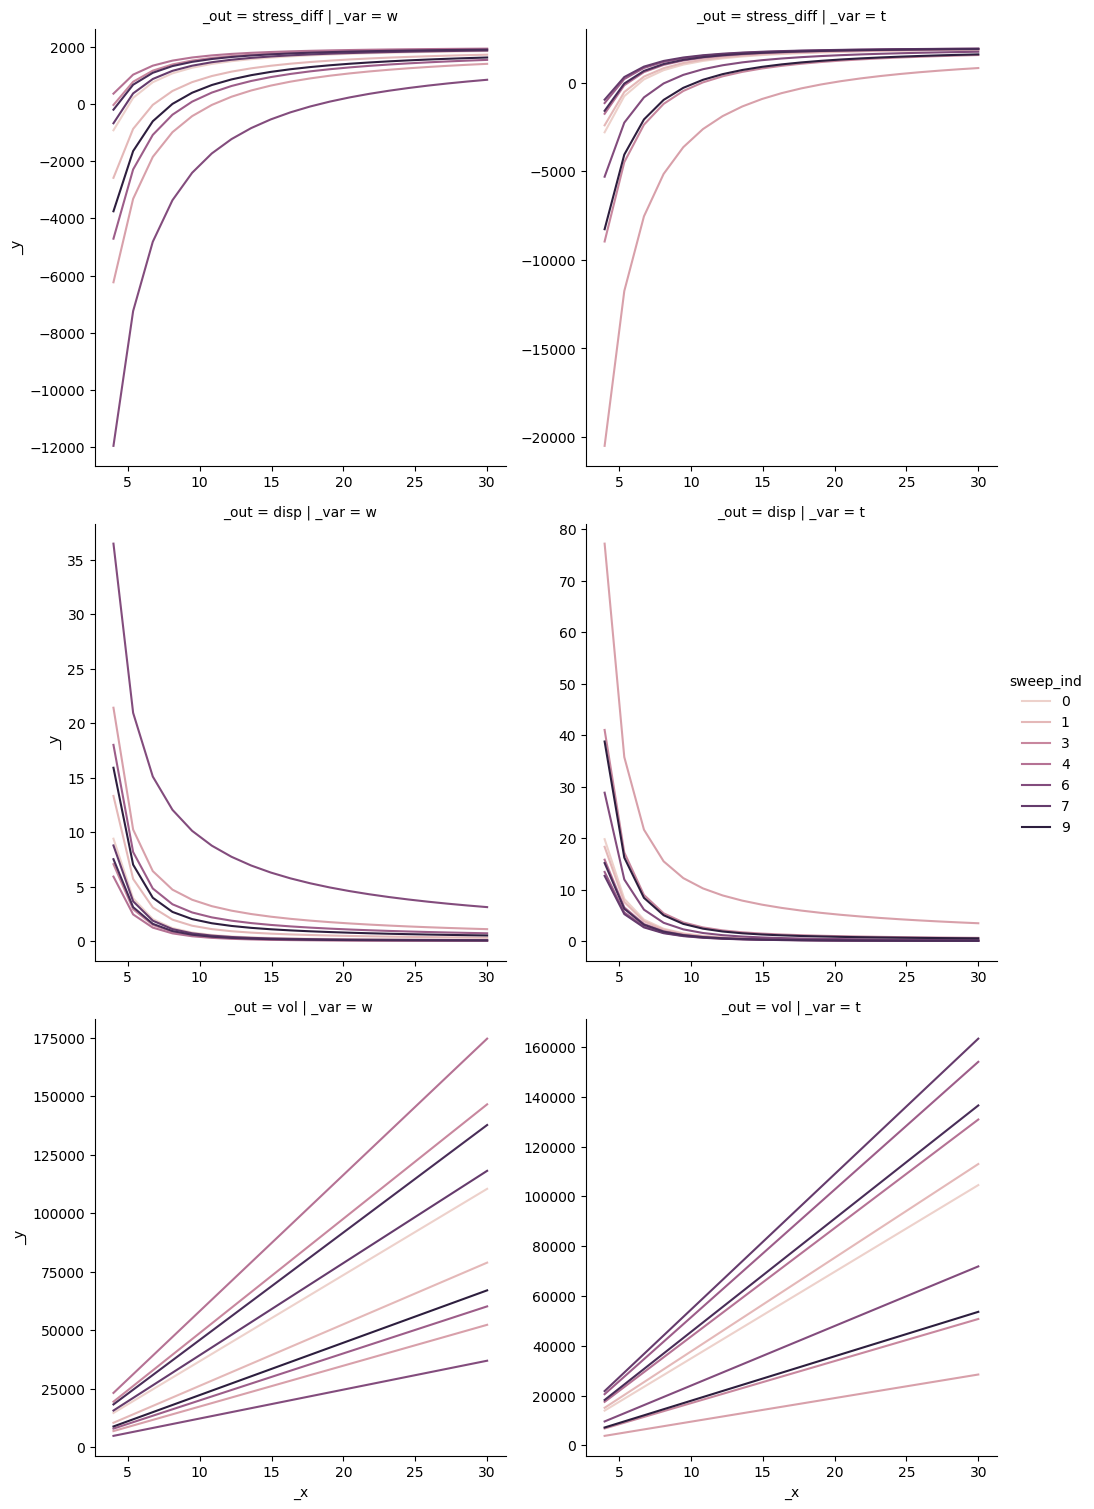

In [17]:
###
# TASK: Assemble the Grama model for the cantilever beam
###
## TASK: Implement this model
## NOTE: Make sure to use gr.cp_vec_function()


md_cantilever = (
    gr.Model("Cantilever Beam")
    >> gr.cp_vec_function(
        fun=fun_volume,
        var=var_cantilever,
        out=out_volume,
    )
    >> gr.cp_vec_function(
        fun=fun_stress_diff,
        var=var_cantilever,
        out=out_stress_diff,
    )
    >> gr.cp_vec_function(
        fun=fun_disp,
        var=var_cantilever,
        out=out_disp,
    )

# NOTE: Use these bounds in your optimization
    >> gr.cp_bounds(
        w=(4, 30),
        t=(4, 30),
    )
)

# NOTE: This will print out a summary of your model
md_cantilever.printpretty()

# NOTE: This will produce the sinew plot
(
    md_cantilever
    >> gr.ev_sinews(df_det="swp", n_sweeps=10, n_density=20, seed=101)
    >> gr.pt_auto()
)


*Note*: Remember that each panel above shows a single output against a single input variable, with all other variables held *constant*.

*Observe*:

- Which variables have a *positive* impact on the following output? Which have a *negative* impact? (Note that I mean *positive* in sign of effect, not in terms of good.)
  - `disp`: Positive impact: 
  - `disp`: Negative impact: w, t
  - `vol`: Positive impact: w, t
  - `vol`: Negative impact: 
  - `stress`: Positive impact: w, t
  - `stress`: Negative impact: 


### q3.2 Scalarize the objectives

Complete the code below to scalarize the two objectives with the weight method. Use the weights provided in `w_vol, w_disp`.

*Note*: Even when you get this right, the code will take a few moments to finish executing.


In [18]:
###
# TASK: Add another function to the model to scalarize
#       the objectives `vol` and `disp`; use the
#       weights w_vol and w_disp
###

# NOTE: No need to edit the scaffold code; just add at the TASK below

# Set the weights for scalarization
w_vol = 1e-4
w_disp_all = np.logspace(-1, +1, 20)

df_all = pd.DataFrame()
# Iterate over all displacement weights
for w_disp in w_disp_all:
    md_tmp = (
        md_cantilever
# TASK: Add another function to the model to scalarize
        >> gr.cp_vec_function(
            fun=lambda df: gr.df_make(
            obj = w_vol*df.vol + w_disp*df.disp
            ),
            var=["vol", "disp"],
            out=["obj"]
        )
        
    )
    
    # NOTE: The following code minimizes your scalarized
    #       objective
    df_res = (
        md_tmp
        >> gr.ev_min(
            out_min="obj",
            out_geq=["stress_diff"],
        )
        >> gr.tf_mutate(
            pareto=gr.pareto_min(DF.disp, DF.vol),
            w_disp=w_disp,
        )
    )
    # Store the results
    df_all = pd.concat((df_all, df_res), axis=0)
# Reset the dataframe index
df_all.reset_index(drop=True, inplace=True)


### q3.3 Visualize and interpret

Visualize the data `df_all` from above with the variables Tip Displacement and Volume. Answer the questions below.


          w          t   w_0   t_0   stress_diff      disp           vol  \
0  7.607551  11.843094  17.0  17.0 -1.107310e-10  2.743737  18019.388149   
1  7.700222  11.712366  17.0  17.0 -6.707523e-12  2.727603  18037.564298   
2  7.787207  11.593244  17.0  17.0 -4.235869e-08  2.714891  18055.799979   
3  7.866843  11.487103  17.0  17.0 -3.857394e-10  2.705231  18073.446202   
4  7.938101  11.394396  17.0  17.0 -4.630258e-07  2.698125  18089.974862   

        obj  success                                message  n_iter  pareto  \
0  2.076313     True  Optimization terminated successfully.      14    True   
1  2.151328     True  Optimization terminated successfully.      14    True   
2  2.246418     True  Optimization terminated successfully.      13    True   
3  2.367094     True  Optimization terminated successfully.      12    True   
4  2.520399     True  Optimization terminated successfully.      12    True   

     w_disp  
0  0.100000  
1  0.127427  
2  0.162378  
3  0.206914 

Text(0, 0.5, 'Tip Displacement (in)')

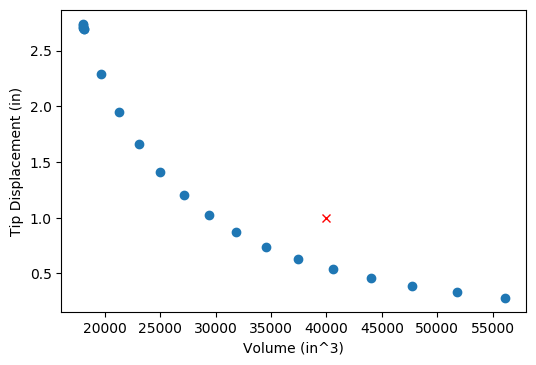

In [19]:
###
# TASK: Visualize your Pareto frontier results; analyze the results
###
# NOTE: Add your results to the following figure
print(df_all.head())
print(w_disp_all)
plt.figure()
plt.plot(40000, 1.0, "rx")
# TASK: Visualize the results in df_all
plt.scatter(df_all.vol, df_all.disp)

plt.xlabel("Volume (in^3)")
plt.ylabel("Tip Displacement (in)")


*Observe*:

- Qualitatively describe the tradeoff: Both Tip Displacement (D) and Volume (V) are to be minimized, but what shape does the frontier have?
  - Displacement decays exponentially with respect to to an increase in volume. 
- At which end of the Pareto frontier do points tend to concentrate? What about the optimization problem can explain this phenomenon?
  - The points are concentrated towards the beginning of the curve with low volume and high displacement. This is due to the logspaced weights given for displacement where most of the weights for displacement have a relatively low value.
- Suppose a customer currently uses a beam sizing at the red `X` pictured above. Based on your Pareto frontier results, what options for improvement would you provide to the customer?
  - Bc the customer's current beam is not optimal there are several ways they could improve their beam. If the customer wanted to keep either beam displacement or volume fixed, they could greatly improve the other variable (e.g. keeping displacement fixed but using a beam with smaller volume). If the customer didn't have a preference for keeping either variable fixed, they could also choose a design that improves both the displacement and volume metrics. 


## Project

---

### __Project Task__

Look back on your project idea from the previous assignment. As we saw in this assignment, many problems have multiple objectives. This project task will help you connect these ideas to your project.

*Task*: Provide an answer to each point below:

- *Stakeholder Concerns*: Last assignment you wrote down your stakeholders' concerns; copy those over here for your reference.
  - Maximize perfomance
  - Reduce Costs
  - High Reliability in harsh environment (space)
- *Multiple objectives*: Are there multiple objectives among your stakeholders' concerns?
  - Maimizing performance and reducing costs.
- *Correlated objectives*: Do you have any reason to believe that any of your objectives are *positively correlated*? 
  - Maximum performance and ability to work in harsh environments might be slightly positively correlated.
  - *Note*: If two objectives are strongly positively correlated, then we need not consider both objectives. We can optimize one, and the other will be optimized "for free".
- *Natural tradeoffs*: Do you have any reason to believe that any of your objectives exhibit *tradeoffs*? Do you have a physical reason to believe this?
  - Minimal cost and maximum performance are likely to be tradeoffs. A larger, light-weight nozzle will likely require advanced materials and additional manufacturing time to produce versus the cheaper nozzles that potentially weigh more or take up less space. Different cooling techniques may also factor into this tradeoff (cheap ablative cooling nozzles vs regeneratively cooled nozzles).
  - *Note*: If two (or more) objectives exhibit a tradeoff, then you'll need to consider all the objectives in your project.


## References

---

- del Rosario *et al.*, "Assessing the frontier: Active learning, model accuracy, and multi-objective candidate discovery and optimization" (2020) *J. Chem. Phys.*, [link](https://aip.scitation.org/doi/full/10.1063/5.0006124)
